In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


from collections import Counter
import matplotlib.pyplot as plt
import urllib.request
import random
import re

### Preparing Data

First, I will download and preprocess the dataset. I have chosen a shakespeare play for this task, it consists of conversations between characters in a story. After downloading the text file, I will 

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
file_path = "shakespeare.txt"

urllib.request.urlretrieve(dataset_url, file_path)

text = open(file_path, 'rb').read().decode(encoding='utf-8')
lines = text.splitlines()

# Remove speaker identifiers
pattern = re.compile(r'^\w+[\w\s]*:', re.MULTILINE)
cleaned_text = re.sub(pattern, '', text)

lines = cleaned_text.split('\n')

# Remove punctuation
cleaned_lines = [re.sub(r"[^a-zA-Z0-9 ']+", '', sentence)
                     for sentence in lines]

# Remove empty lines and lowercase text
cleaned_lines = [line.strip().lower()
                 for line in cleaned_lines if line.strip() != '']

# Remove single word sentences
cleaned_lines = [line for line in cleaned_lines if len(line.split()) > 1]

### Tokenizer
Then, I will write a custom tokenizer, which can tokenize a list of sentences. First, it will go through all of the words in all sentences and it will create a map of word:word_id. Then, by calling the function `tokenize`, it will substitute each word with its ID. It can also take list of token IDs and return a list of corresponding words.

In [3]:
class Tokenizer:
    def __init__(self, texts):
        self.vocab = self.build_vocab(texts)
        self.id_to_word = {id: word for word, id in self.vocab.items()}
        self.pad_token_id = 0
        self.unk_token_id = 1

    def build_vocab(self, texts):
        # Start vocab from 1 since 0 is reserved for pad
        vocab = {"<PAD>": 0, "<UNK>":1}
        words = [word for sentence in texts for word in sentence.split()]
        word_counts = Counter(words)
        for word, _ in word_counts.items():
            vocab[word] = len(vocab)
        return vocab

    def tokenize(self, texts):
        max_len = max(len(sentence.split()) for sentence in texts)
        tokenized_texts = []
        for sentence in texts:
            tokens = [self.vocab.get(word, self.unk_token_id)
                      for word in sentence.split()]
            # Pad sequences
            tokens += [0] * (max_len - len(tokens))
            tokenized_texts.append(tokens)
        return tokenized_texts

    def decode(self, token_id):
        return self.id_to_word.get(token_id, '')

    def vocab_size(self):
        return len(self.vocab)

In [6]:
# Take a subset of the data for faster training
random.seed(42)
random.shuffle(cleaned_lines)

subset_size = int(len(cleaned_lines) * 0.3)
subset = random.sample(cleaned_lines, subset_size)

split_idx = int(subset_size * 0.8)
train_subset = subset[:split_idx]
test_subset = subset[split_idx:]

tokenizer = Tokenizer(subset)
vocab_size = tokenizer.vocab_size()
print(f"Vocab size: {vocab_size}")


tokenized_sentences = tokenizer.tokenize(subset)

input_ids = torch.tensor(tokenized_sentences)

dataset = TensorDataset(input_ids)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

Vocab size: 6232


### Defining Models

In [5]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.hidden_size = hidden_size

        self.input_hidden = nn.Linear(embed_dim, hidden_size, bias=False)
        self.hidden_hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden_output = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        x = self.input_hidden(embedded).squeeze(1)
        hidden_state = self.hidden_hidden(hidden)
        hidden_state = torch.tanh(x + hidden_state)
        output = self.hidden_output(hidden_state)
        return output, hidden_state
    
    def zero_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size)

In [6]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.hidden_size = hidden_size

        self.input_gate = nn.Linear(embed_dim + hidden_size, hidden_size)
        self.forget_gate = nn.Linear(embed_dim + hidden_size, hidden_size)
        self.output_gate = nn.Linear(embed_dim + hidden_size, hidden_size)
        self.cell_gate = nn.Linear(embed_dim + hidden_size, hidden_size)

        self.hidden_output = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        embedded = self.embedding(x)

        if embedded.dim() == 3 and embedded.size(1) == 1:
            embedded = embedded.squeeze(1) 
    
        combined = torch.cat((embedded, h_prev), 1)

        i_t = torch.sigmoid(self.input_gate(combined))
        f_t = torch.sigmoid(self.forget_gate(combined))
        o_t = torch.sigmoid(self.output_gate(combined))
        g_t = torch.tanh(self.cell_gate(combined))

        # Update cell state
        c_t = f_t * c_prev + i_t * g_t

        # Update hidden state
        h_t = o_t * torch.tanh(c_t)

        output = self.hidden_output(h_t)

        return output, (h_t, c_t)

    def zero_hidden(self, batch_size=1):
        return (torch.zeros(batch_size, self.hidden_size),
                torch.zeros(batch_size, self.hidden_size))

In [7]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

In [8]:
def train(model, dataloader, optimizer, criterion, device, epochs=10):
    model.apply(init_weights)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            input_ids = input_ids.squeeze(0)
            input_ids = input_ids[torch.nonzero(input_ids).squeeze()]
            input_ids = input_ids.unsqueeze(0)
            batch_size, seq_len = input_ids.size()
            
            hidden = model.zero_hidden(batch_size)
            if isinstance(hidden, tuple):
                hidden = tuple(h.to(device) for h in hidden)
            else:
                hidden = hidden.to(device)

            loss = torch.zeros(1, requires_grad=True).to(device)
            for i in range(seq_len - 1):
                inputs = input_ids[:, i].unsqueeze(1)
                targets = input_ids[:, i + 1]

                outputs, hidden = model(inputs, hidden)

                loss += criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() / (seq_len - 1)
            
        loss_history.append(total_loss / len(dataloader))
        print(f'\tEpoch {epoch + 1}, Loss: {total_loss / len(dataloader)}')
    return loss_history

In [20]:
def generate_text(model, initial_text, word_limit, tokenizer, device='cpu'):
    model.eval()
    model.to(device)
    generated_text = initial_text

    tokens = tokenizer.tokenize([initial_text])[0]
    input_ids = torch.tensor(tokens).unsqueeze(0).to(device)
    hidden = model.zero_hidden(1)
    if isinstance(hidden, tuple):
        hidden = tuple(h.to(device) for h in hidden)
    else:
        hidden = hidden.to(device)

    with torch.no_grad():
        for i in range(input_ids.size(1)):
            output, hidden = model(input_ids[:, i:i+1], hidden)

    for _ in range(word_limit - len(tokens)):
        with torch.no_grad():
            output, hidden = model(input_ids[:, -1:], hidden)
            
            softmax_logits = torch.softmax(output, dim=-1)
            predicted_token_id = torch.multinomial(softmax_logits, 1).item()

            input_ids = torch.cat((input_ids, torch.tensor([[predicted_token_id]]).to(device)), dim=1)

            predicted_word = tokenizer.decode(predicted_token_id)
            generated_text += ' ' + predicted_word

    return generated_text

In [10]:
def plot_losses(losses, text='Training Loss'):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(text)
    plt.show()

In [11]:
embed_dim = 256
hidden_size = 256

rnn_model = RNN(vocab_size, embed_dim, hidden_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")
rnn_model.to(device)

hist_rnn = train(rnn_model, dataloader, optimizer, criterion, device, epochs=20)

Using cuda device
	Epoch 1, Loss: 7.1211757465944805
	Epoch 2, Loss: 6.200281991278274
	Epoch 3, Loss: 5.583916519119659
	Epoch 4, Loss: 4.997114877851482
	Epoch 5, Loss: 4.432554884232443
	Epoch 6, Loss: 3.9455322800036643
	Epoch 7, Loss: 3.5669721091317395
	Epoch 8, Loss: 3.279097101113325
	Epoch 9, Loss: 3.0740323708840256
	Epoch 10, Loss: 2.906776584300145
	Epoch 11, Loss: 2.794184347053162
	Epoch 12, Loss: 2.700620729578047
	Epoch 13, Loss: 2.629173932293174
	Epoch 14, Loss: 2.576448476477064
	Epoch 15, Loss: 2.5199551763269183
	Epoch 16, Loss: 2.484302373614526
	Epoch 17, Loss: 2.4528944867135687
	Epoch 18, Loss: 2.417555490780128
	Epoch 19, Loss: 2.4199795420286945
	Epoch 20, Loss: 2.38873211540969


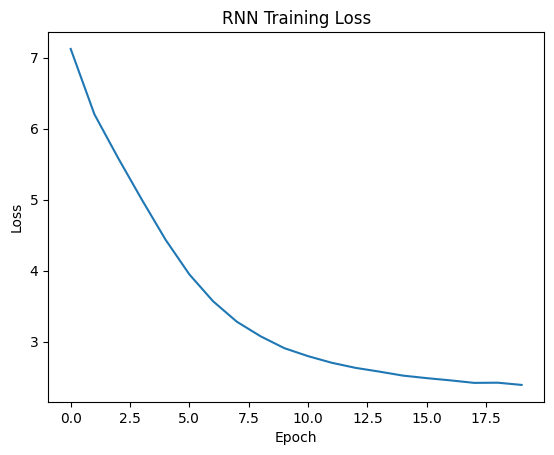

In [12]:
plot_losses(hist_rnn, "RNN Training Loss")

In [21]:
print(generate_text(rnn_model, "this", 20, tokenizer, device))

this the hand to fill his doing one person understand the say is great gentleman of act country be found


In [22]:
print(generate_text(rnn_model, "this", 100, tokenizer, device))

this sport mine hath rest work truth your mother but their voice of time to stir away from him of an envious worm their love's just and sir as i would i madam before i should be to yourself to burgundy the old sheepwhistling peace with this fool to way suffer it were not too that i name them shall not thursday ever if not before endured out and what's in secret rome and the dare trust my honesty is and hear a tale to a woman whose love to make bold quick up your susan use hang o'clock beseem


In [15]:
embed_dim = 256
hidden_size = 256

lstm_model = LSTM(vocab_size, embed_dim, hidden_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")
lstm_model.to(device)
 
hist_lstm = train(lstm_model, dataloader, optimizer, criterion, device, epochs=20)

Using cuda device
	Epoch 1, Loss: 7.068196606741619
	Epoch 2, Loss: 6.179205142104117
	Epoch 3, Loss: 5.5901796861855235
	Epoch 4, Loss: 4.964203760127271
	Epoch 5, Loss: 4.297733810127921
	Epoch 6, Loss: 3.684323488213247
	Epoch 7, Loss: 3.176257311923541
	Epoch 8, Loss: 2.77101518901352
	Epoch 9, Loss: 2.4412504955944505
	Epoch 10, Loss: 2.192492526749242
	Epoch 11, Loss: 1.9814567608887068
	Epoch 12, Loss: 1.8175137637274092
	Epoch 13, Loss: 1.6922610211636444
	Epoch 14, Loss: 1.5916643216994102
	Epoch 15, Loss: 1.5233672609423714
	Epoch 16, Loss: 1.4660252012992236
	Epoch 17, Loss: 1.4121483781607678
	Epoch 18, Loss: 1.365613569513901
	Epoch 19, Loss: 1.3257823313491388
	Epoch 20, Loss: 1.3062017729541442


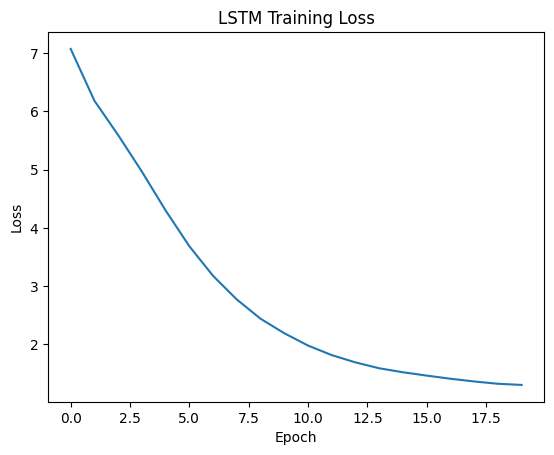

In [16]:
plot_losses(hist_lstm, "LSTM Training Loss")

In [23]:
print(generate_text(lstm_model, "this", 20, tokenizer, device))

this fair nor you say mocking lives in rich charge a justice where by this heart' speak thing my lords


In [24]:
print(generate_text(lstm_model, "this", 100, tokenizer, device))

this is king of thee till give mine own you while sweet party farewell their great present person old drunk i will come on way to her answer his tongue that might thus stoop to have done there a fool if i am a wild dedication of yourselves silence i'll my mother run only me do well aid your sword let her be slave too slave i call like honour to berkeley and weep one one too duke seek of hoxes and being excused in my counsels goes forward to this feat say home well weep thou hast i sent


By comparing the loss plots, we can see that with the same hyperparameters and number of iterations, LSTM can reduce the training loss better and learn faster. 